# Segmenting buildings

## Setup

In [1]:
! git clone https://github.com/kbrodt/building-segmentation-disaster-resilience.git

Cloning into 'building-segmentation-disaster-resilience'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20 (delta 0), reused 20 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [2]:
! pip install -q -U albumentations
! pip install -q pystac
! pip install -q rasterio
! pip install -q segmentation-models-pytorch

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 952kB 11.4MB/s 
     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 18.2MB 74.9MB/s 
     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 61kB 3.4MB/s 


If the `curl` command below doesn't work, download the models (the *last_1024_pl2_ft.zip*) from https://yadi.sk/d/RDSYG6PzSlc5dQ.

In [3]:
! curl 'https://s542sas.storage.yandex.net/rdisk/f8da5198af6181a7fb7b99daf5f9c1421fd8896ffc79c638758558fa92c434d6/5f1feccb/07iRs4PdUB8voNYfmA6CIMt32w91wl3gOrArEN2XWKji49IHjW_QWr3LlJV3PUSVxhELd6jl-SWO1gPMjprtXw==?uid=0&filename=last_1024_pl2_ft.zip&disposition=attachment&hash=96H63%2BOHuQFrVgIOFCt8yw8iWK7M4X/6s6JzuJ3ZPgMy/5z/T/vvPln/UbprHLUtq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=314339253&fsize=988247458&hid=d583cc5468bf9136e1dd7a66392a31df&media_type=compressed&tknv=v2&rtoken=TejbOL1anNP8&force_default=no&ycrid=na-89d108fa739843a9606ab1d0a6a1f1bc-downloader22f&ts=5ab7ce2ec88c0&s=673f42fc4d51117995ba05965530d537c6bc5ac19d5cea9867c71cb2c2f04b4d&pb=U2FsdGVkX1_0orLn-TYJfLSFT17HLO4qw_eisQt5jZmeYZHmbTQonCpYkOfK9AB_0NbxqZvmBfOCA5ZZNS2IY_MNZ8rq-VHkFoBcKr5xHFQ' -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Referer: https://yadi.sk/d/RDSYG6PzSlc5dQ' -H 'Connection: keep-alive' -H 'Upgrade-Insecure-Requests: 1' --output last_1024_pl2_ft.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  942M  100  942M    0     0  9404k      0  0:01:42  0:01:42 --:--:-- 9558k


In [4]:
! unzip last_1024_pl2_ft.zip -d last_1024_pl2_ft

Archive:  last_1024_pl2_ft.zip
  inflating: last_1024_pl2_ft/efficientnet-b4_b18_adam_lr0.0001_c0_fold0_z0_w3m0_t20_hm0/model_best.pt  
  inflating: last_1024_pl2_ft/densenet161_b16_adam_lr0.0001_c0_fold1_z0_w3m0_t20_hm0/model_best.pt  
  inflating: last_1024_pl2_ft/se_resnext50_32x4d_b26_adam_lr0.0001_c0_fold3_z0_w3m0_t20_hm0/model_best.pt  
  inflating: last_1024_pl2_ft/senet154_b12_adam_lr0.0001_c0_fold4_z0_w3m0_t20_hm0/model_best.pt  
  inflating: last_1024_pl2_ft/inceptionv4_b28_adam_lr0.0001_c0_fold3_z0_w3m0_t20_hm0/model_best.pt  


In [5]:
from google.colab import drive
import os, sys, shutil as sh
from pathlib import Path
import PIL, albumentations as A
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm

In [6]:
drive.mount('/content/drive')
dir_mydrive = Path('/content/drive/My Drive')
sys.path.append('building-segmentation-disaster-resilience/src')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
def _cp(src, dst):
    import shutil
    assert src.is_file()
    shutil.copy(src, dst)

Path.cp = _cp
Path.ls = lambda x: list(x.iterdir())

## Get some test images

In [8]:
dir_sg = (dir_mydrive/'Official Folder for Engie project'/
          'Data'/'Satellite Imagery'/'Main Island'/'JPEG_tiles_Main')

Just test on a few of the Singapore tiles.

In [9]:
fns = dir_sg.ls()[510:510+5]
fns

[PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Main Island/JPEG_tiles_Main/main_5200_2800.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Main Island/JPEG_tiles_Main/main_5200_6400.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Main Island/JPEG_tiles_Main/main_5200_5600.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Main Island/JPEG_tiles_Main/main_5200_7200.jpeg'),
 PosixPath('/content/drive/My Drive/Official Folder for Engie project/Data/Satellite Imagery/Main Island/JPEG_tiles_Main/main_5200_6800.jpeg')]

In [10]:
dir_test = Path('/content/test_jpegs')
dir_test.mkdir(exist_ok=True)
for fn in fns: 
    fn.cp(dir_test/f'{fn.stem}.jpg')   # the '.jpg' suffix is required

## Segment the buildings in the test images

In [11]:
import argparse
from dataset import dev_transform
from utils import read_img

In [12]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default='./data/test_tiles_1024',
                        help='Path to data')
    parser.add_argument('--exp', type=str, required=True,
                        help='Path to models checkpoints in jit format')
    parser.add_argument('--to-save', type=str, required=True,
                        help='Folder path to save test masks')
    
    parser.add_argument('--n-parts', type=int, default=1)
    parser.add_argument('--part', type=int, default=0)
    
    parser.add_argument('--res', type=int, default=512,
                        help='Image resolution')
    parser.add_argument('--batch-size', type=int, default=32)

    return parser.parse_args([f'--data={dir_test}', f'--exp={dir_models}', f'--to-save={dir_results}',])

class DS(torch.utils.data.Dataset):
    def __init__(self, imgs, root):
        self.imgs = imgs
        self.root = root

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img_id = self.imgs[index]
        
        img = read_img(self.root / img_id)
        mask = np.zeros_like(img)[..., [0]]

        return dev_transform(img, mask)[0], img_id


def collate(x):
    x, y = list(zip(*x))

    return torch.stack(x), y


def main():
    args = parse_args()
    path_to_data = Path(args.data)
    print(args)

    test_anns = [p.name for p in (path_to_data).glob('*.jpg')]
    
    n = len(test_anns)
    k = n//args.n_parts
    start = args.part*k
    end = k*(args.part + 1) if args.part + 1 != args.n_parts else n
    test_anns = test_anns[start:end]
    print(f'test size: {len(test_anns)}')
    
    batch_size = args.batch_size
    batch_size = batch_size if args.res != 1024 else batch_size//4
    ds = DS(test_anns, path_to_data)
    loader = torch.utils.data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        shuffle=False,
        collate_fn=collate,
        pin_memory=True,
    )

    models = [
        torch.jit.load(str(p)).cuda().eval()
        for p in Path(args.exp).rglob('*.pt')
    ]
    print(f'#models: {len(models)}')
    n_models = len(models)
    tta = 4
    n_augs = n_models * tta
    
    to_save = Path(args.to_save)
    print(f'save path: {to_save}')
    if not to_save.exists():
        to_save.mkdir(parents=True)

    def get_submit(thresh_dice=None):
        masks = torch.zeros((batch_size, 1 if thresh_dice is not None else 2, args.res, args.res), dtype=torch.float32, device='cuda')
        with torch.no_grad():
            with tqdm.tqdm(loader, mininterval=2) as pbar:
                for img, anns in pbar:
                    bs = img.size(0)
                    img = img.cuda()

                    masks.zero_()
                    for model in models:
                        mask = model(img)
                        if thresh_dice is not None:
                            masks[:bs] += torch.sigmoid(mask)
                        else:
                            masks[:bs] += torch.softmax(mask, dim=1)

                        # vertical flip
                        if tta > 1:
                            mask = model(torch.flip(img, dims=[-1]))
                            if thresh_dice is not None:
                                masks[:bs] += torch.flip(torch.sigmoid(mask), dims=[-1])
                            else:
                                masks[:bs] += torch.flip(torch.softmax(mask, dim=1), dims=[-1])

                        # horizontal flip
                        if tta > 2:
                            mask = model(torch.flip(img, dims=[-2]))
                            if thresh_dice is not None:
                                masks[:bs] += torch.flip(torch.sigmoid(mask), dims=[-2])
                            else:
                                masks[:bs] += torch.flip(torch.softmax(mask, dim=1), dims=[-2])

                        if tta > 3:
                            # vertical + horizontal flip
                            mask = model(torch.flip(img, dims=[-1, -2]))
                            if thresh_dice is not None:
                                masks[:bs] += torch.flip(torch.sigmoid(mask), dims=[-1, -2])
                            else:
                                masks[:bs] += torch.flip(torch.softmax(mask, dim=1), dims=[-1, -2])

                    masks /= n_augs
                    for mask, annotation in zip(masks, anns):
                        if thresh_dice is None:
                            mask = mask.argmax(0)[None]

                        for cls, m in enumerate(mask):
                            if thresh_dice is not None:
                                m = m > thresh_dice

                            m = m.cpu().numpy().astype('float32')
                            if args.res != 1024:
                                m = A.Resize(1024, 1024)(image=np.zeros((512, 512, 3), dtype='uint8'),
                                                         mask=m)['mask']

                            m = PIL.Image.fromarray(((m*255).astype('uint8')/255).astype('uint8'))
                            m.save(str(to_save / annotation.replace('.jpg', '.TIF')), compression='tiff_deflate')

    get_submit()

In [13]:
# Define where the models' parameters are and where to save the predicted segmentation masks.
dir_results = Path('/content/test_results/')
dir_models = Path('/content/last_1024_pl2_ft')

In [14]:
main()

Namespace(batch_size=32, data='/content/test_jpegs', exp='/content/last_1024_pl2_ft', n_parts=1, part=0, res=512, to_save='/content/test_results')
test size: 5


  0%|          | 0/1 [00:00<?, ?it/s]

#models: 5
save path: /content/test_results


100%|██████████| 1/1 [00:16<00:00, 16.22s/it]


In [15]:
dir_results.ls()

[PosixPath('/content/test_results/main_5200_7200.TIF'),
 PosixPath('/content/test_results/main_5200_6400.TIF'),
 PosixPath('/content/test_results/main_5200_6800.TIF'),
 PosixPath('/content/test_results/main_5200_2800.TIF'),
 PosixPath('/content/test_results/main_5200_5600.TIF')]

## Plot the predicted mask over the image

In [31]:
tileid = '5200_5600'

In [32]:
mask = PIL.Image.open(f'{dir_results}/main_{tileid}.TIF')
img = PIL.Image.open(f'{dir_test}/main_{tileid}.jpg').resize(size=mask.size)
mask, img = np.array(mask), np.array(img)

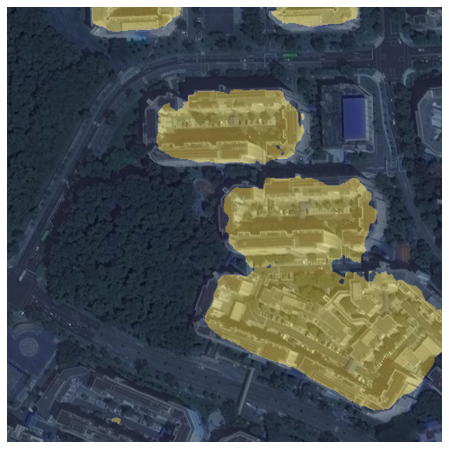

In [33]:
_, ax = plt.subplots(figsize=(8, 8))
ax.axis('off')
ax.imshow(img)
ax.imshow(mask, alpha=.35, cmap='cividis');

## Reference


* [Kirill Brodt's solution for the *Open Cities AI Challenge: Segmenting Buildings for Disaster Resilience*](https://github.com/kbrodt/building-segmentation-disaster-resilience)